<a href="https://colab.research.google.com/github/yann112/Cast_Iron/blob/main/Cast_Iron_densenet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Test des gpu
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [8]:
#import des librairies
import os
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option("max_colwidth", None)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

#DataViz

In [5]:
#compter les fichier dans les dossiers
liste_fichier = []
for path, dirs, files in os.walk('/content/drive/MyDrive/Projet_casting/casting_data/casting_data'):
  for i in enumerate(dirs):
    liste_fichier.append(str(path)+'/'+str(i[1]))
for i in liste_fichier:
  n = len(os.listdir(i))
  print('il y a ',n,' élements dans le dossier : ',i)

il y a  2  élements dans le dossier :  /content/drive/MyDrive/Projet_casting/casting_data/casting_data/test
il y a  2  élements dans le dossier :  /content/drive/MyDrive/Projet_casting/casting_data/casting_data/train
il y a  453  élements dans le dossier :  /content/drive/MyDrive/Projet_casting/casting_data/casting_data/test/def_front
il y a  262  élements dans le dossier :  /content/drive/MyDrive/Projet_casting/casting_data/casting_data/test/ok_front
il y a  3758  élements dans le dossier :  /content/drive/MyDrive/Projet_casting/casting_data/casting_data/train/def_front
il y a  2875  élements dans le dossier :  /content/drive/MyDrive/Projet_casting/casting_data/casting_data/train/ok_front


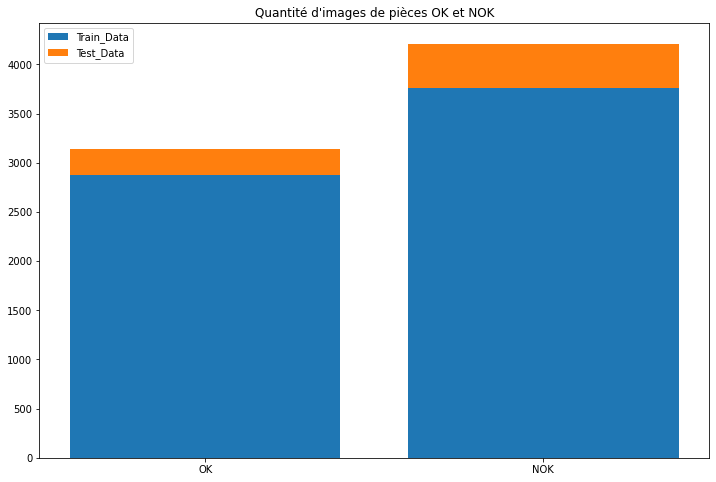

In [6]:
#Dataviz Dataset
labels = ['OK', 'NOK']
train = [2875, 3758]
test = [262, 453]
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(labels, train,label='Train_Data')
ax.bar(labels, test, bottom=train, label='Test_Data')
ax.set_title('Quantité d\'images de pièces OK et NOK');
ax.legend();

<Figure size 432x288 with 0 Axes>

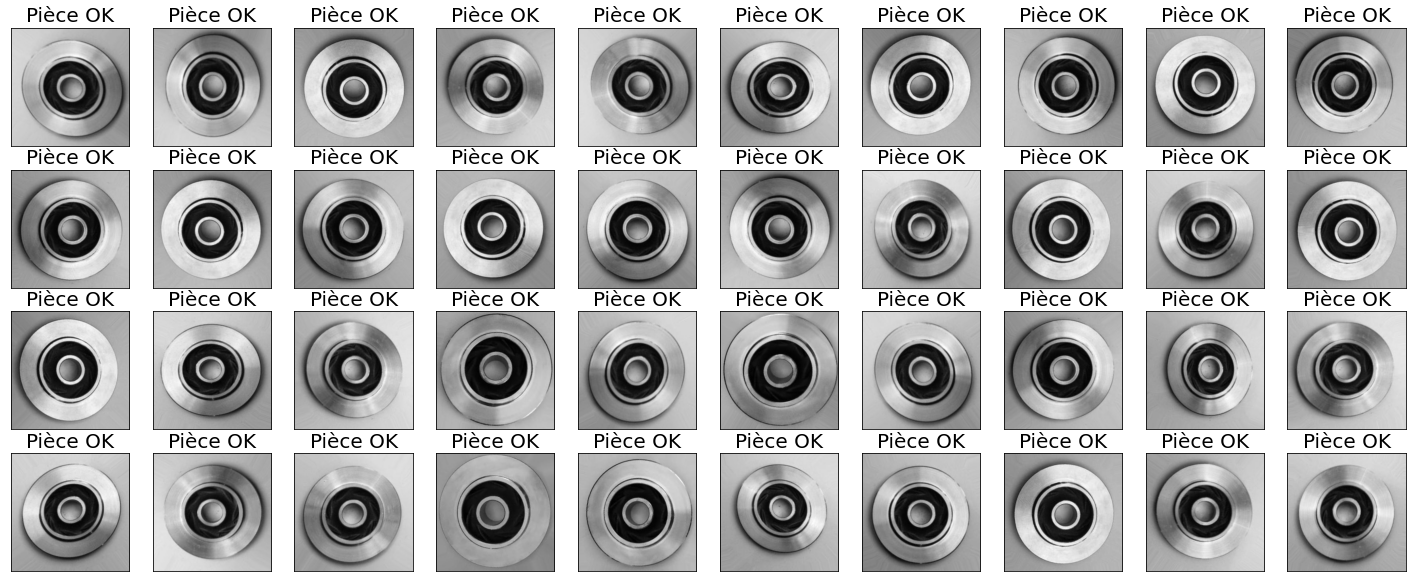

In [27]:
#piéces OK
liste_ok = []
for files in os.listdir('/content/drive/MyDrive/Projet_casting/casting_data/casting_data/train/ok_front'):
    liste_ok.append(str(files))

plt.figure();

fig, ax = plt.subplots(4, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(25,10));
for i, axi in enumerate(ax.flat):
    axi.set_title('Pièce OK', fontdict = {'fontsize' : 20}) 
    img = plt.imread('/content/drive/MyDrive/Projet_casting/casting_data/casting_data/train/ok_front/'+str(liste_ok[i]))
    axi.imshow(img);


<Figure size 432x288 with 0 Axes>

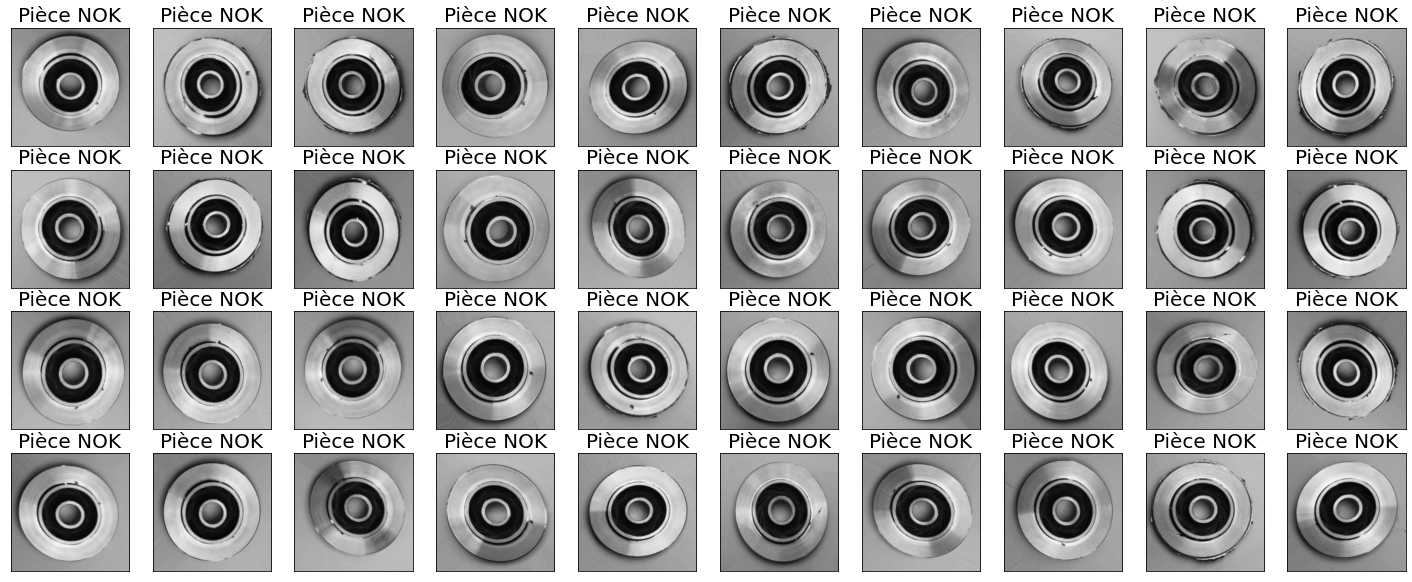

In [28]:
#piéces NOK
liste_nok = []
for files in os.listdir('/content/drive/MyDrive/Projet_casting/casting_data/casting_data/train/def_front'):
    liste_nok.append(str(files))

plt.figure();

fig, ax = plt.subplots(4, 10, subplot_kw=dict(xticks=[], yticks=[]),figsize=(25,10));
for i, axi in enumerate(ax.flat):
    axi.set_title('Pièce NOK', fontdict = {'fontsize' : 20}) 
    img = plt.imread('/content/drive/MyDrive/Projet_casting/casting_data/casting_data/train/def_front/'+str(liste_nok[i]))
    axi.imshow(img);

In [ ]:
#nombre de classe
n_class = 2 

# Préparation des données

## Générateur de données

### Application du pre_processing

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

### Itérateur

In [ ]:
train_generator = train_data_generator.flow_from_directory(
                                                directory=r"/content/drive/MyDrive/Projet_casting/casting_data/casting_data/train",
                                                target_size=(512, 512),
                                                color_mode="rgb",
                                                batch_size=32,
                                                class_mode="sparse",
                                                shuffle=True,
                                                seed=42
                                            )

test_generator = test_data_generator.flow_from_directory(
                                                directory=r"/content/drive/MyDrive/Projet_casting/casting_data/casting_data/test",
                                                target_size=(512, 512),
                                                color_mode="rgb",
                                                batch_size=32,
                                                class_mode="sparse",
                                                shuffle=False,
                                                seed=42
                                            )

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


# Mise en place du modèle

### Implémentation du modèle

In [ ]:
from tensorflow.keras.applications import DenseNet201


# Modèle de base
base_model = DenseNet201(
    include_top=False,
    weights= "imagenet",
    input_tensor=None,
    input_shape=(512,512,3),
    pooling=None,
    classes=1000,
)
# Freezer les couches
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1967104   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

### Entrainement du modèle

In [ ]:
#executé en 1713 Secondes gpu = P100
history = model.fit(train_generator, 
                                epochs = 5,
                                validation_data = test_generator,
                                )

Epoch 1/5
208/208 [==============================] - 2131s 10s/step - loss: 0.1792 - acc: 0.9195 - val_loss: 0.0471 - val_acc: 0.9902
Epoch 2/5
208/208 [==============================] - 88s 421ms/step - loss: 0.0626 - acc: 0.9804 - val_loss: 0.0382 - val_acc: 0.9874
Epoch 3/5
208/208 [==============================] - 88s 421ms/step - loss: 0.0537 - acc: 0.9815 - val_loss: 0.0299 - val_acc: 0.9916
Epoch 4/5
208/208 [==============================] - 88s 423ms/step - loss: 0.0491 - acc: 0.9845 - val_loss: 0.0971 - val_acc: 0.9664
Epoch 5/5
208/208 [==============================] - 88s 424ms/step - loss: 0.0264 - acc: 0.9935 - val_loss: 0.0231 - val_acc: 0.9930


### Affichage de la courbe de la fonction de coût et de précision en fonction de l'epoch.

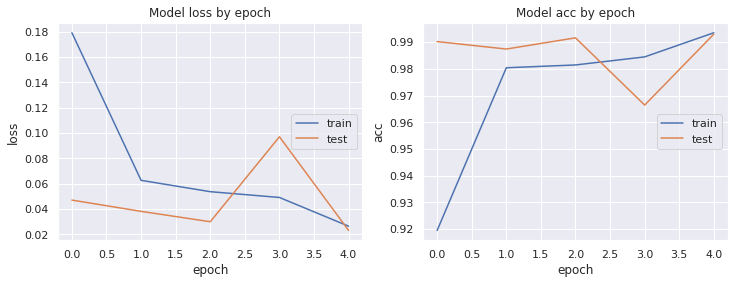

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
#Sauvegarde de l'historique
import pickle
with open('/content/drive/MyDrive/Projet_casting/history_Densenet_1', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [ ]:
#Import de l'historique
with open('/content/drive/MyDrive/Projet_casting/history_densenet_1', 'rb') as pickle_file:
    history.history = pickle.load(pickle_file)

In [ ]:
#Sauvegarde de l'entrainement du modèle
model.save('/content/drive/MyDrive/Projet_casting/model_densenet_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projet_casting/model_densenet_1/assets


# Analyse du modèle 

In [ ]:
#Import de l'entrainement du modèle
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/Projet_casting/model_densenet_1')

In [ ]:
#Prediction sur les données de Validation
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)
print()
print('Classification Report')
target_names = ['OK','NOK'] 
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


Confusion Matrix
[[449   4]
 [  1 261]]

Classification Report
              precision    recall  f1-score   support

          OK       1.00      0.99      0.99       453
         Nok       0.98      1.00      0.99       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



### On voit que 5 images ont été mal classées

In [ ]:
#acceder à la position des images classées faux_negatif
faux_negatif = []
for i, j in enumerate(y_pred.tolist()):
    if j == 1:
      if test_generator.classes[i] == 0 :
          faux_negatif.append(i)
len(faux_negatif)

4

In [ ]:
path = '/content/drive/MyDrive/Projet_casting/casting_data/casting_data/test/'
filenames=test_generator.filenames


<Figure size 432x288 with 0 Axes>

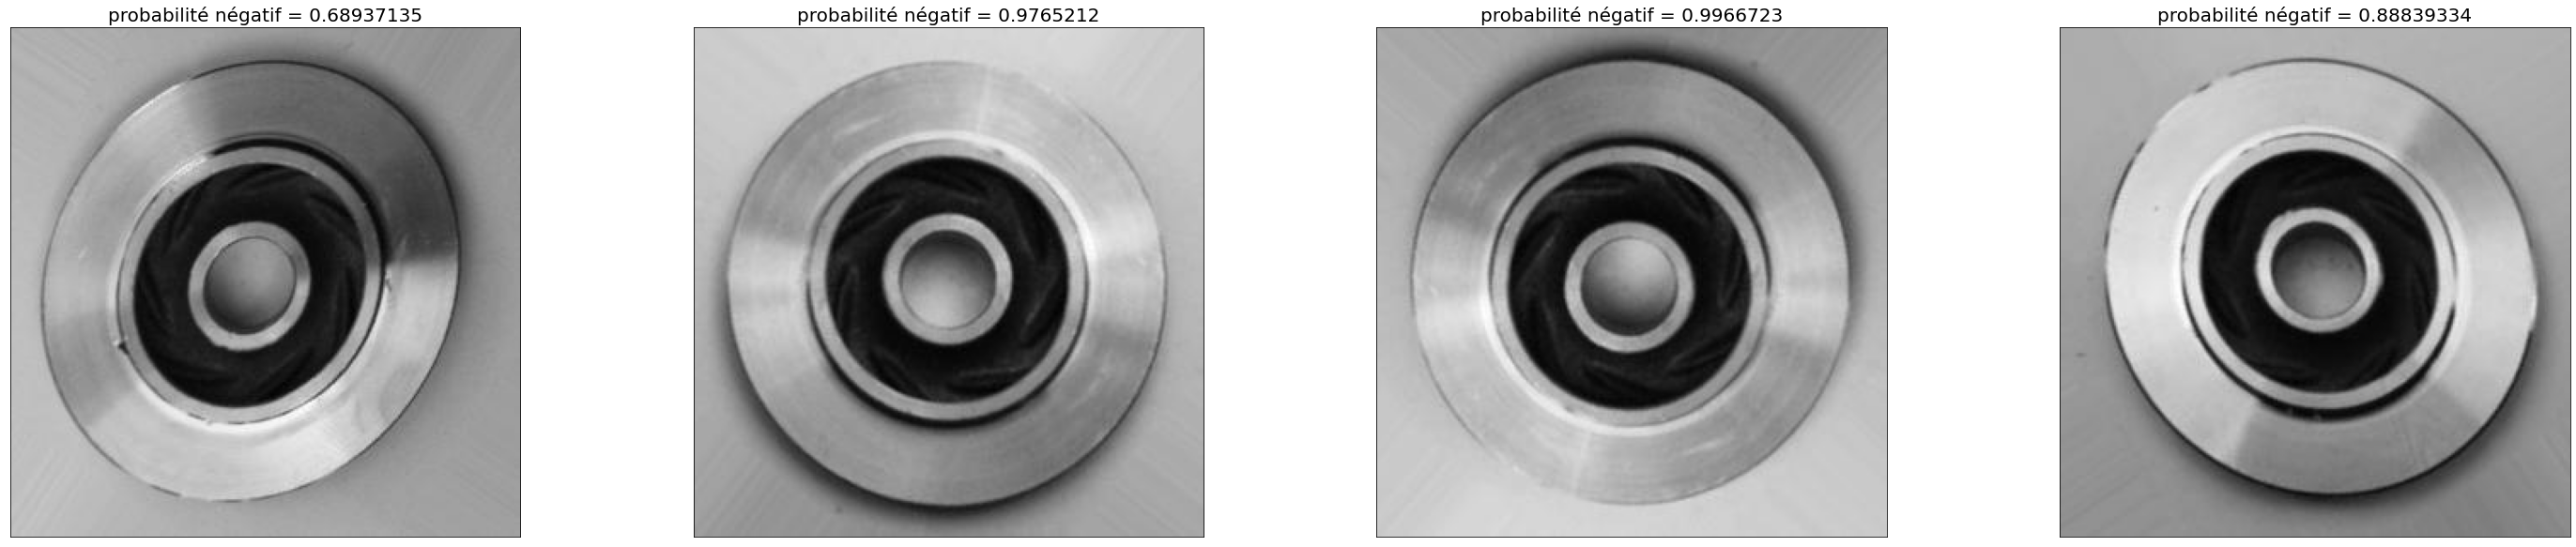

In [ ]:
#faux negatif

plt.figure();

fig, ax = plt.subplots(1, 4, subplot_kw=dict(xticks=[], yticks=[]),figsize=(50,10));

for i, axi in enumerate(ax.flat):
    axi.set_title('probabilité négatif = ' + str(Y_pred[faux_negatif[i]][1]), fontdict = {'fontsize' : 20}) 
    img = plt.imread(path + filenames[faux_negatif[i]])
    axi.imshow(img);

In [ ]:
#moyenne des piéces classées NOK
moyenne_neg = []
t= 0
for i in Y_pred:
  if Y_pred[t][0] <= 0.5:
    moyenne_neg.append(Y_pred[t][1])
  t+=1
import statistics

statistics.mean(moyenne_neg )

0.9901849

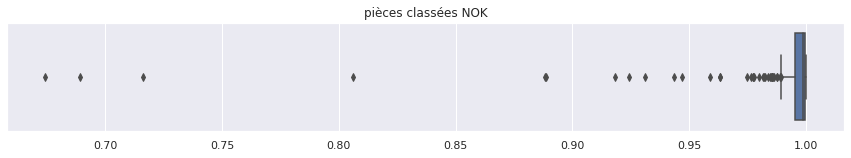

In [ ]:
#pièces classées NOK
sns.set(rc={'figure.figsize':(15,2)})
sns.boxplot(x = moyenne_neg).set_title('pièces classées NOK');

In [ ]:
#moyenne des piéces classées positives
moyenne_pos = []
t= 0
for i in Y_pred:
  if Y_pred[t][0] >= 0.5:
    moyenne_pos.append(Y_pred[t][0])
  t+=1
import statistics

print(statistics.mean(moyenne_pos )) 

0.99847937


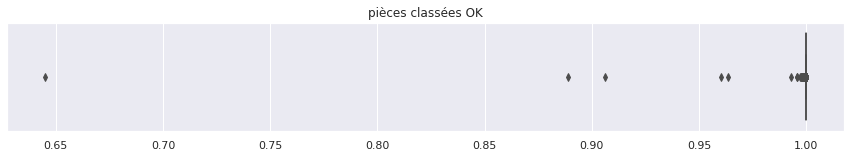

In [ ]:
#pièce classées OK
sns.set(rc={'figure.figsize':(15,2)})
sns.boxplot(x = moyenne_pos).set_title('pièces classées OK');

In [ ]:
#acceder à la position des images classees faux_positf
faux_positif = []
for i, j in enumerate(y_pred.tolist()):
    if j == 0:
      if test_generator.classes[i] == 1 :
          faux_positif.append(i)
len(faux_positif)

1

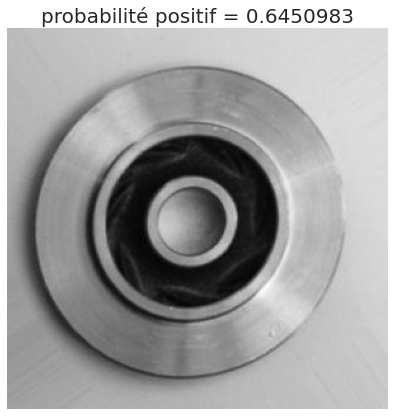

In [ ]:
#faux positif

plt.figure(figsize= (7,7));
plt.title('probabilité positif = ' + str(Y_pred[faux_positif[0]][0]), fontdict = {'fontsize' : 20})
plt.axis('off') 
img = plt.imread(path + filenames[faux_positif[0]])
plt.imshow(img);